<a href="https://www.kaggle.com/code/ravaghi/cibmtr-autogluon-training?scriptVersionId=226031797" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports and configs

In [1]:
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter
from sklearn.preprocessing import quantile_transform
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import KFold
from scipy.stats import rankdata 
from numba import jit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import shutil

warnings.filterwarnings("ignore")

In [2]:
# Reference: https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/discussion/555029

@jit(nopython=True)
def init_BTree(values):
    times_to_compare = np.empty_like(values)
    last_full_row = int(np.log2(len(values) + 1) - 1)
    len_ragged_row = len(values) - (2 ** (last_full_row + 1) - 1)
    if len_ragged_row > 0:
        bottom_row_ix = slice(None, 2 * len_ragged_row, 2)
        times_to_compare[-len_ragged_row:] = values[bottom_row_ix]
        values = np.delete(values, bottom_row_ix)
    values_start = 0
    values_space = 2
    values_len = 2 ** last_full_row
    while values_start < len(values):
        times_to_compare[values_len - 1: 2 * values_len - 1] = values[values_start::values_space]
        values_start += int(values_space / 2)
        values_space *= 2
        values_len = int(values_len / 2)
    return times_to_compare


@jit(nopython=True)
def insert(counts, pred, times_to_compare):
    i = 0
    n = len(times_to_compare)
    while (i < n):
        cur = times_to_compare[i]
        counts[i] += 1
        if pred < cur:
            i = 2 * i + 1
        elif pred > cur:
            i = 2 * i + 2
        else:
            return counts


@jit(nopython=True)
def fn_rank(pred, times_to_compare, counts):
    i = 0
    n = len(times_to_compare)
    rank = 0
    count = 0
    while (i < n):
        cur = times_to_compare[i]
        if pred < cur:
            i = 2 * i + 1
            continue
        elif pred > cur:
            rank += counts[i]
            nexti = 2 * i + 2
            if nexti < n:
                rank -= counts[nexti]
                i = nexti
                continue
            else:
                return rank, count
        else:
            count = counts[i]
            lefti = 2 * i + 1
            if lefti < n:
                nleft = counts[lefti]
                count -= nleft
                rank += nleft
                righti = lefti + 1
                if righti < n:
                    count -= counts[righti]
            return rank, count
    return rank, count


@jit(nopython=True)
def handle_pairs(truth, pred, first_ix, times_to_compare, counts):
    next_ix = first_ix
    while next_ix < len(truth) and truth[next_ix] == truth[first_ix]:
        next_ix += 1
    pairs = counts[0] * (next_ix - first_ix)
    correct = np.int64(0)
    tied = np.int64(0)
    for i in range(first_ix, next_ix):
        rank, count = fn_rank(pred[i], times_to_compare, counts)
        correct += rank
        tied += count
    return (pairs, correct, tied, next_ix)


@jit(nopython=True)
def fast_concordance_index(event_times, predicted_event_times, event_observed):
    died_mask = event_observed == 1
    died_truth = event_times[died_mask]
    ix = np.argsort(died_truth)
    died_truth = died_truth[ix]
    died_pred = predicted_event_times[died_mask][ix]

    censored_truth = event_times[~died_mask]
    ix = np.argsort(censored_truth)
    censored_truth = censored_truth[ix]
    censored_pred = predicted_event_times[~died_mask][ix]

    censored_ix = 0
    died_ix = 0

    times_to_compare = init_BTree(np.unique(died_pred))
    counts = np.full(len(times_to_compare), 0)

    num_pairs = np.int64(0)
    num_correct = np.int64(0)
    num_tied = np.int64(0)

    while True:
        has_more_censored = censored_ix < len(censored_truth)
        has_more_died = died_ix < len(died_truth)
        if has_more_censored and (not has_more_died or died_truth[died_ix] > censored_truth[censored_ix]):
            pairs, correct, tied, next_ix = handle_pairs(censored_truth, censored_pred, censored_ix, times_to_compare, counts)
            censored_ix = next_ix

        elif has_more_died and (not has_more_censored or died_truth[died_ix] <= censored_truth[censored_ix]):
            pairs, correct, tied, next_ix = handle_pairs(died_truth, died_pred, died_ix, times_to_compare, counts)
            for pred in died_pred[died_ix:next_ix]:
                insert(counts, pred, times_to_compare)
            died_ix = next_ix
        else:
            assert not (has_more_died or has_more_censored)
            break

        num_pairs += pairs
        num_correct += correct
        num_tied += tied

    return (num_correct + num_tied / 2) / num_pairs


def score_f(y_true, y_pred, return_details=False):
    races = [
        "More than one race", "Asian", "White", "American Indian or Alaska Native",
        "Native Hawaiian or other Pacific Islander", "Black or African-American"
    ]

    metric_list = []
    for race in races:
        mask = y_true.race_group.values == race
        if isinstance(y_pred, pd.Series):
            c_index_race = fast_concordance_index(y_true.efs_time[mask].values, -y_pred[mask].values.ravel(), y_true.efs[mask].values)
        else:
            c_index_race = fast_concordance_index(y_true.efs_time[mask].values, -y_pred[mask].ravel(), y_true.efs[mask].values)
        metric_list.append(c_index_race)

    if return_details:
        return np.mean(metric_list) - np.std(metric_list), np.mean(metric_list), np.std(metric_list)
    else:
        return np.mean(metric_list) - np.std(metric_list)

In [3]:
class CFG:
    train_path = "/kaggle/input/equity-post-HCT-survival-predictions/train.csv"
    test_path = "/kaggle/input/equity-post-HCT-survival-predictions/test.csv"
    sample_sub_path = "/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv"

    n_folds = 10
    seed = 42

    time_limit = 3600 * 11

    # target = "cox"
    #/target = "kaplan_meier"
    # target = "nelson_aalen"
    # target = "separate"
    # target = "rank_log"
    # target = "quantile"
    target = "exponential_rank"

    run_name = f"ag_{target}"

# Loading and preprocessing data

In [4]:
class TargetTransformer:
    def __init__(self, y_train, y_test):
        self.y_train = y_train
        self.y_test = y_test
        
    def create_cox_target(self):
        # https://www.kaggle.com/code/andreasbis/cibmtr-eda-ensemble-model
        
        y_train = pd.DataFrame({"efs_time": self.y_train.efs_time, "efs": self.y_train.efs, "time": self.y_train.efs_time, "event": self.y_train.efs})
        y_test = pd.DataFrame({"efs_time": self.y_test.efs_time, "efs": self.y_test.efs, "time": self.y_test.efs_time, "event": self.y_test.efs})
        
        cph = CoxPHFitter()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            cph.fit(y_train, duration_col="time", event_col="event")
            
        y_train = cph.predict_partial_hazard(y_train)
        y_test = cph.predict_partial_hazard(y_test)

        return y_train, y_test
    
    def create_kaplan_meier_target(self):
        kmf = KaplanMeierFitter()
        kmf.fit(durations=self.y_train.efs_time, event_observed=self.y_train.efs)
        
        y_train = kmf.survival_function_at_times(self.y_train.efs_time).values
        y_test = kmf.survival_function_at_times(self.y_test.efs_time).values

        return y_train, y_test
    
    def create_nelson_aalen_target(self):
        naf = NelsonAalenFitter()
        naf.fit(durations=self.y_train.efs_time, event_observed=self.y_train.efs)
        
        y_train = naf.cumulative_hazard_at_times(self.y_train.efs_time).values * -1
        y_test = naf.cumulative_hazard_at_times(self.y_test.efs_time).values * -1

        return y_train, y_test
    
    def create_cox_loss_target(self, time, event):
        return np.where(event == 1, time, -time)
    
    def create_separate_target(self, time, event):
        # https://www.kaggle.com/code/mtinti/cibmtr-lofo-feature-importance-gpu-accelerated
        transformed = time.values.copy()
        mx = transformed[event == 1].max() # last patient who dies
        mn = transformed[event == 0].min() # first patient who survives
        transformed[event == 0] = time[event == 0] + mx - mn
        transformed = rankdata(transformed)
        transformed[event == 0] += len(transformed) // 2
        transformed = transformed / transformed.max()
        return - transformed
    
    def create_rank_log_target(self, time, event):
        # https://www.kaggle.com/code/ambrosm/esp-eda-which-makes-sense
        transformed = time.values.copy()
        mx = transformed[event == 1].max() # last patient who dies
        mn = transformed[event == 0].min() # first patient who survives
        transformed[event == 0] = time[event == 0] + mx - mn
        transformed = rankdata(transformed)
        transformed[event == 0] += len(transformed) * 2
        transformed = transformed / transformed.max()
        transformed = np.log(transformed)
        return - transformed
    
    def create_quantile_target(self, time, event):
        # https://www.kaggle.com/code/ambrosm/esp-eda-which-makes-sense
        transformed = np.full(len(time), np.nan)
        transformed_dead = quantile_transform(- time[event == 1].values.reshape(-1, 1)).ravel()
        transformed[event == 1] = transformed_dead
        transformed[event == 0] = transformed_dead.min() - 0.3
        return transformed

    def create_exponential_rank_target(self, time, event):
        transformed = time.values.copy()
        death_times = transformed[event == 1]
        transformed[event == 1] = np.exp(rankdata(death_times) / len(death_times))
        max_death = transformed[event == 1].max()
        transformed[event == 0] = max_death + 0.2
        transformed = (transformed - transformed.min()) / (transformed.max() - transformed.min())
        return -transformed

    def fit_transform(self, target_name):
        target_transformers_1 = {
            "cox": self.create_cox_target,
            "kaplan_meier": self.create_kaplan_meier_target,
            "nelson_aalen": self.create_nelson_aalen_target
        }

        target_transformers_2 = {
            "cox_loss": self.create_cox_loss_target,
            "separate": self.create_separate_target,
            "rank_log": self.create_rank_log_target,
            "quantile": self.create_quantile_target,
            "exponential_rank": self.create_exponential_rank_target,
        }

        if target_name in target_transformers_1.keys():
            return target_transformers_1[target_name]()

        else:
            y_train_time = self.y_train.efs_time
            y_train_event = self.y_train.efs

            y_test_time = self.y_test.efs_time
            y_test_event = self.y_test.efs

            y_train = target_transformers_2[target_name](y_train_time, y_train_event)
            y_test = target_transformers_2[target_name](y_test_time, y_test_event)

            return y_train, y_test

In [5]:
train = pd.read_csv(CFG.train_path)

In [6]:
kf = KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = kf.split(train, train[["efs", "efs_time"]])

for i, (train_index, val_index) in enumerate(split):
    train.loc[val_index, "fold"] = i
    
    train.loc[train_index, CFG.target], train.loc[val_index, CFG.target] = TargetTransformer(
        train.loc[train_index, ["efs", "efs_time"]], 
        train.loc[val_index, ["efs", "efs_time"]]
    ).fit_transform(CFG.target)

In [7]:
train = train.drop(["ID", "efs", "efs_time"], axis=1)

# Training

In [8]:
predictor = TabularPredictor(
    path=f"/{CFG.run_name}",
    problem_type="regression",
    eval_metric="rmse",
    label=CFG.target,
    groups="fold",
    verbosity=2
)

In [9]:
predictor.fit(
    train_data=train,
    time_limit=CFG.time_limit,
    presets="best_quality",
    excluded_model_types=["KNN"],
    keep_only_best=True
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       30.24 GB / 31.35 GB (96.5%)
Disk Space Avail:   1892.08 GB / 8062.39 GB (23.5%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stac

(_ray_fit pid=4189) [1000]	valid_set's rmse: 0.322433
(_ray_fit pid=4191) [2000]	valid_set's rmse: 0.325097 [repeated 4x across cluster]
(_ray_fit pid=4316) [1000]	valid_set's rmse: 0.325257 [repeated 3x across cluster]
(_ray_fit pid=4347) [1000]	valid_set's rmse: 0.329178
(_ray_fit pid=4351) [1000]	valid_set's rmse: 0.323198
(_ray_fit pid=4351) [2000]	valid_set's rmse: 0.322791 [repeated 2x across cluster]


(_dystack pid=174) 	-0.3242	 = Validation score   (-root_mean_squared_error)
(_dystack pid=174) 	39.78s	 = Training   runtime
(_dystack pid=174) 	6.9s	 = Validation runtime
(_dystack pid=174) Fitting model: NeuralNetFastAI_r191_BAG_L1 ... Training model for up to 3529.99s of the 6830.20s of remaining time.
(_dystack pid=174) 	Fitting 9 child models (S1F1 - S1F9) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.20%)
(_ray_fit pid=4489) No improvement since epoch 11: early stopping
(_ray_fit pid=4490) No improvement since epoch 13: early stopping [repeated 2x across cluster]
(_ray_fit pid=4636) No improvement since epoch 15: early stopping
(_ray_fit pid=4709) No improvement since epoch 19: early stopping
(_ray_fit pid=4746) No improvement since epoch 13: early stopping
(_ray_fit pid=4782) No improvement since epoch 10: early stopping
(_dystack pid=174) 	-0.3292	 = Validation score   (-root_mean_squared_error)
(_dystack pid=174) 	338.1s	 = Training

(_ray_fit pid=5210) [1000]	valid_set's rmse: 0.317294 [repeated 3x across cluster]
(_ray_fit pid=5212) [2000]	valid_set's rmse: 0.319661 [repeated 4x across cluster]
(_ray_fit pid=5212) [3000]	valid_set's rmse: 0.31926 [repeated 4x across cluster]
(_ray_fit pid=5212) [4000]	valid_set's rmse: 0.319408 [repeated 4x across cluster]
(_ray_fit pid=5336) [1000]	valid_set's rmse: 0.324753 [repeated 2x across cluster]
(_ray_fit pid=5398) [1000]	valid_set's rmse: 0.32367 [repeated 3x across cluster]
(_ray_fit pid=5398) [2000]	valid_set's rmse: 0.32216 [repeated 4x across cluster]
(_ray_fit pid=5398) [3000]	valid_set's rmse: 0.321974 [repeated 3x across cluster]
(_ray_fit pid=5465) [2000]	valid_set's rmse: 0.324636 [repeated 3x across cluster]


(_dystack pid=174) 	-0.3227	 = Validation score   (-root_mean_squared_error)
(_dystack pid=174) 	76.61s	 = Training   runtime
(_dystack pid=174) 	6.91s	 = Validation runtime
(_dystack pid=174) Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 2827.65s of the 6127.86s of remaining time.
(_dystack pid=174) 	Fitting 9 child models (S1F1 - S1F9) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.11%)
(_dystack pid=174) 	-0.3561	 = Validation score   (-root_mean_squared_error)
(_dystack pid=174) 	179.95s	 = Training   runtime
(_dystack pid=174) 	0.91s	 = Validation runtime
(_dystack pid=174) Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 2645.25s of the 5945.45s of remaining time.
(_dystack pid=174) 	Fitting 9 child models (S1F1 - S1F9) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.72%)
(_dystack pid=174) 	-0.3257	 = Validation score   (-root_mean_squared_error)
(_dystack p

In [10]:
predictor.leaderboard(silent=True).style.background_gradient(subset=["score_val"], cmap="RdYlGn")

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.321053,root_mean_squared_error,202.724681,18787.642595,0.000735,0.124619,3,True,52
1,CatBoost_r50_BAG_L2,-0.321286,root_mean_squared_error,188.438439,16727.197001,0.380401,37.799319,2,True,48
2,CatBoost_r70_BAG_L2,-0.321312,root_mean_squared_error,188.415132,16772.489235,0.357095,83.091553,2,True,51
3,CatBoost_r177_BAG_L2,-0.321379,root_mean_squared_error,188.363348,16735.385039,0.305311,45.987357,2,True,43
4,NeuralNetFastAI_r143_BAG_L2,-0.321604,root_mean_squared_error,188.841665,16799.629003,0.783627,110.231321,2,True,50
5,XGBoost_r89_BAG_L2,-0.321772,root_mean_squared_error,188.805047,16716.643340,0.747010,27.245658,2,True,46
6,XGBoost_BAG_L2,-0.322261,root_mean_squared_error,189.031930,16731.967290,0.973893,42.569608,2,True,42
7,NeuralNetFastAI_r145_BAG_L2,-0.322321,root_mean_squared_error,191.081800,17112.198240,3.023762,422.800558,2,True,45
8,NeuralNetFastAI_r191_BAG_L2,-0.322409,root_mean_squared_error,190.270378,17079.715827,2.212340,390.318145,2,True,44
9,CatBoost_BAG_L1,-0.322414,root_mean_squared_error,0.738629,2324.335057,0.738629,2324.335057,1,True,3


# Saving predictor and OOF preds

In [11]:
_train = pd.read_csv(CFG.train_path)

In [12]:
oof_preds = {}
overall_scores = {}
best_model = predictor.model_best
for model in predictor.model_names():
    model_oof_preds = predictor.predict_oof(model).values
    oof_preds[model] = model_oof_preds

    y_true = _train[["efs", "efs_time", "race_group"]].copy()
    
    overall_scores[model] = [score_f(y_true, model_oof_preds)]

In [13]:
joblib.dump(oof_preds[best_model], f"{CFG.run_name}_oof_preds.pkl")

['ag_exponential_rank_oof_preds.pkl']

In [14]:
shutil.make_archive(
    f"/kaggle/working/{CFG.run_name}", 
    "zip", 
    f"/{CFG.run_name}"
)

'/kaggle/working/ag_exponential_rank.zip'

# Results

In [15]:
scores = {}
split = KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed).split(train, train[CFG.target])
for fold_idx, (train_index, val_index) in enumerate(split):
    for model in predictor.model_names():

        y_true_fold = _train.iloc[val_index][["efs", "efs_time", "race_group"]].copy()
        y_pred_fold = oof_preds[model][val_index]
        
        fold_score = score_f(y_true_fold, y_pred_fold)

        if model not in scores:
            scores[model] = []
        scores[model].append(fold_score)

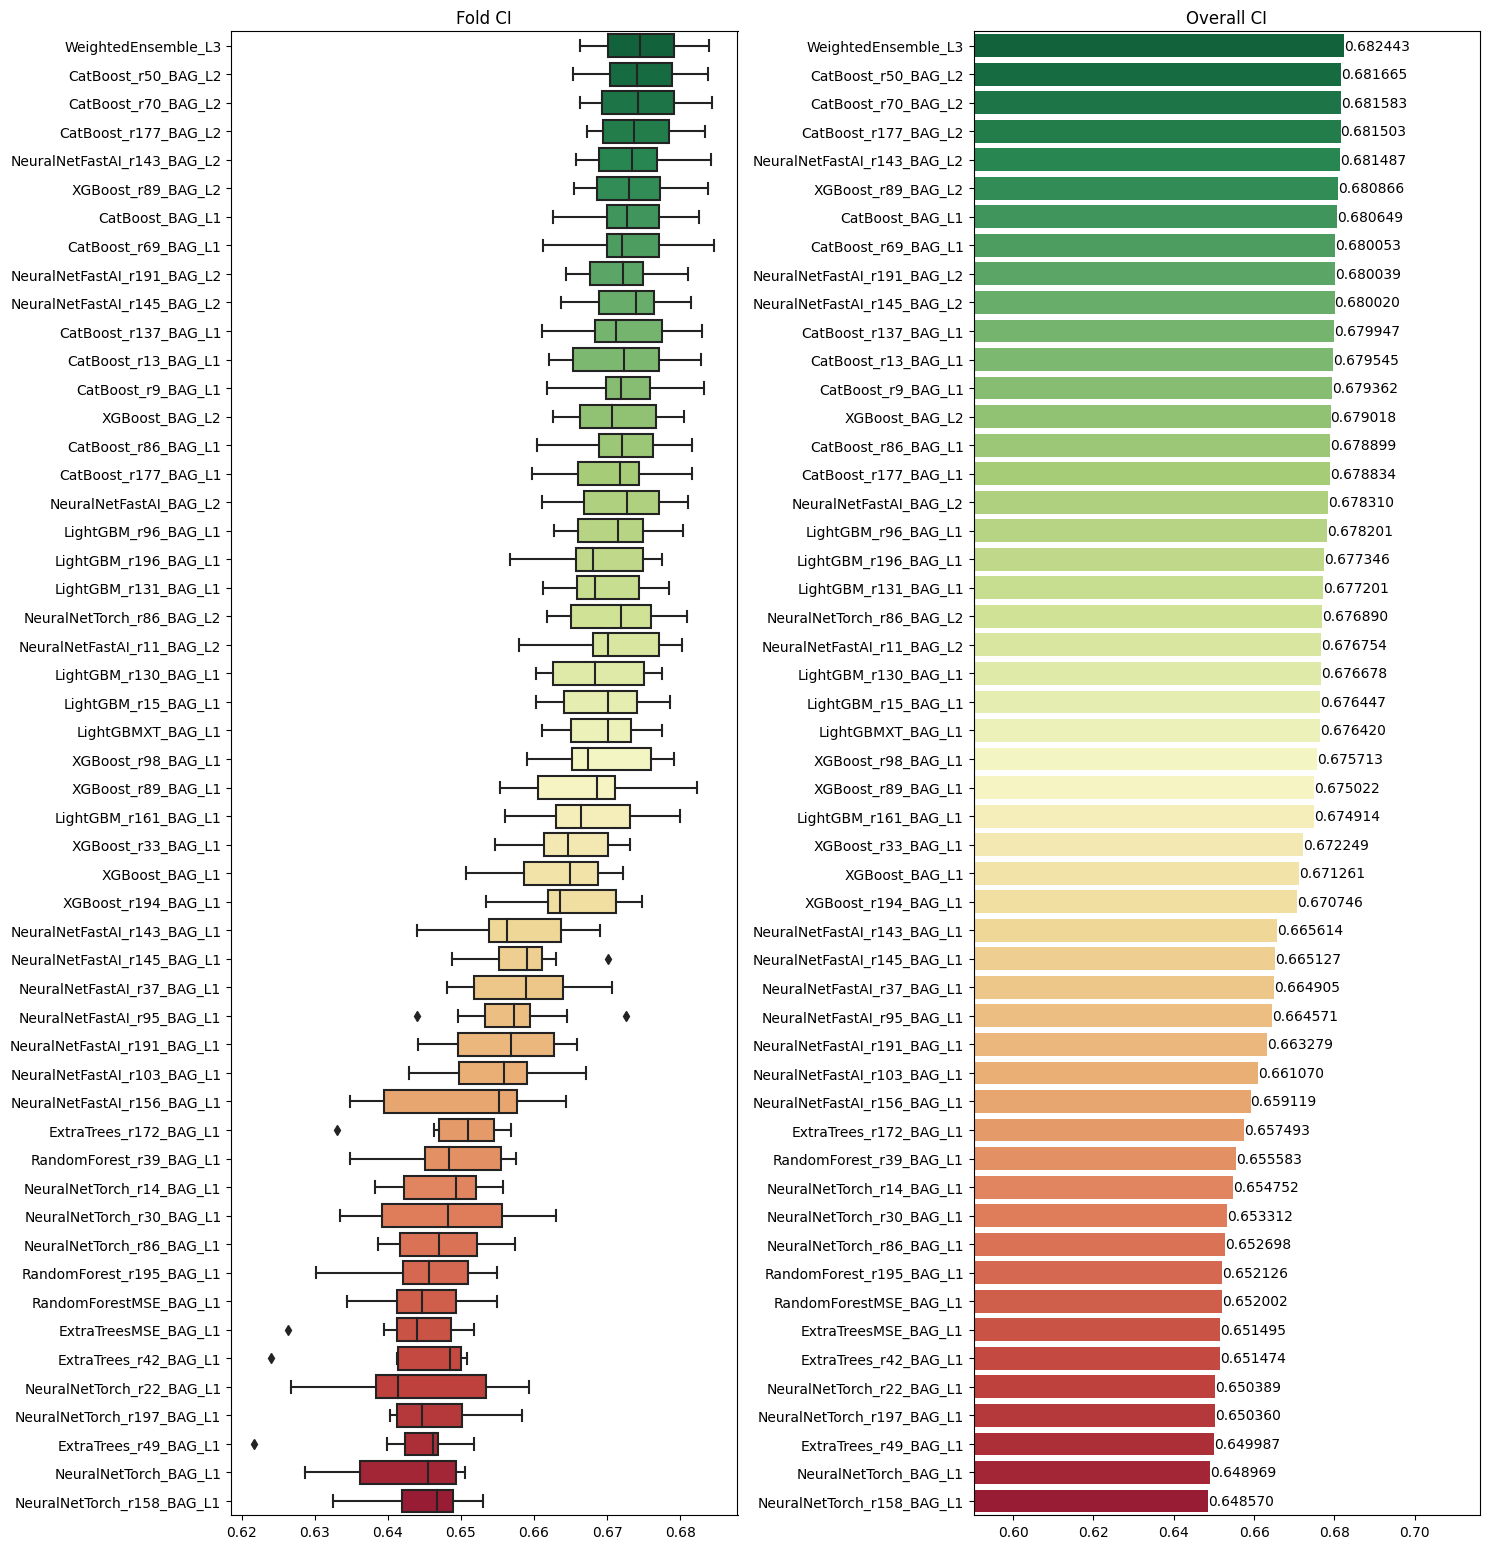

In [16]:
scores_df = pd.DataFrame(scores)
overall_scores_series = pd.Series({k: v[0] for k, v in overall_scores.items()})
order = overall_scores_series.sort_values(ascending=False).index.tolist()

min_score = min(scores_df.min().min(), overall_scores_series.min())
max_score = max(scores_df.max().max(), overall_scores_series.max())
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, len(scores) * 0.3))

sns.boxplot(data=scores_df, order=order, ax=axs[0], orient="h", palette="RdYlGn_r")
axs[0].set_title("Fold CI")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=overall_scores_series, y=overall_scores_series.index, ax=axs[1], palette="RdYlGn_r", order=order)
axs[1].set_title("Overall CI")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, score in enumerate(overall_scores_series[order]):
    barplot.text(score, i, f"{score:.6f}", va="center")

plt.tight_layout()
plt.show()